# Simulating morphological Golgi cell with ``braincell``

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/main/docs/braincell_morphological_golgi_cell.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/main/docs/braincell_morphological_golgi_cell.ipynb)

In [91]:
import os.path

import braincell
import brainstate
import braintools
import brainunit as u
import numpy as np

In [92]:
brainstate.environ.set(dt=0.01 * u.ms, precision=64)

## Golgi cell model

In [93]:
class Golgi(braincell.MultiCompartment):
    def __init__(self, popsize, morphology, el, gl, gh1, gh2, ek, gkv11, gkv34, gkv43, ena, gnarsg, V_init=-65):
        super().__init__(
            popsize=popsize,
            morphology=morphology,
            V_th=20. * u.mV,
            V_initializer=braintools.init.Constant(V_init * u.mV),
            spk_fun=braintools.surrogate.ReluGrad(),
            solver='staggered'
        )

        self.IL = braincell.channel.IL(self.varshape, E=el * u.mV, g_max=gl * u.mS / (u.cm ** 2))
        self.Ih1 = braincell.channel.Ih1_Ma2020(self.varshape, E=-20. * u.mV, g_max=gh1 * u.mS / (u.cm ** 2))
        self.Ih2 = braincell.channel.Ih2_Ma2020(self.varshape, E=-20. * u.mV, g_max=gh2 * u.mS / (u.cm ** 2))

        self.k = braincell.ion.PotassiumFixed(self.varshape, E=ek * u.mV)
        self.k.add(IKv11=braincell.channel.IKv11_Ak2007(self.varshape, g_max=gkv11 * u.mS / (u.cm ** 2)))
        self.k.add(IKv34=braincell.channel.IKv34_Ma2020(self.varshape, g_max=gkv34 * u.mS / (u.cm ** 2)))
        self.k.add(IKv43=braincell.channel.IKv43_Ma2020(self.varshape, g_max=gkv43 * u.mS / (u.cm ** 2)))

        self.na = braincell.ion.SodiumFixed(self.varshape, E=ena * u.mV)
        self.na.add(INa_Rsg=braincell.channel.INa_Rsg(self.varshape, g_max=gnarsg * u.mS / (u.cm ** 2)))

    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value

## Utility functions

In [94]:
def step_input(num, dur, amp, dt):
    brainstate.environ.set(dt=dt * u.ms)
    value = u.math.zeros((len(dur), num))
    for i in range(len(value)):
        value = value.at[i, 0].set(amp[i])
    return braintools.input.section(values=value, durations=dur * u.ms) * u.nA

In [95]:
import matplotlib.pyplot as plt


def plot_voltage_comparison(
    t_vec,
    v_vecs,
    indices=None,
    title="Voltage Comparison",
    xlabel="Time (ms)",
    ylabel="Voltage (mV)",
    figsize=(7, 4),
    legend=True,
    grid=True
):
    if indices is None:
        indices = range(len(v_vecs))
    plt.figure(figsize=figsize)
    for idx, i in enumerate(indices):
        plt.plot(t_vec, v_vecs[i], linewidth=2)
    if legend:
        plt.legend(frameon=False, fontsize=11)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.title(title, fontsize=15, weight='bold')
    if grid:
        plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

In [96]:
# index for ion channel
def is_basal(idx):
    return (
        0 <= idx <= 3
        or 16 <= idx <= 17
        or 33 <= idx <= 41
        or idx == 84
        or 105 <= idx <= 150
    )


def is_apical(idx):
    return (
        4 <= idx <= 15
        or 18 <= idx <= 32
        or 42 <= idx <= 83
        or 85 <= idx <= 104
    )


def seg_ion_params(morphology):
    # segment index for each type
    index_soma = []
    index_axon = []
    index_dend_basal = []
    index_dend_apical = []

    for i, seg in enumerate(morphology.segments):
        name = str(seg.section_name)
        if name.startswith("soma"):
            index_soma.append(i)
        elif name.startswith("axon"):
            index_axon.append(i)
        elif name.startswith("dend_"):
            idx = int(name.split("_")[-1])
            if is_basal(idx):
                index_dend_basal.append(i)
            if is_apical(idx):
                index_dend_apical.append(i)

    n_compartments = len(morphology.segments)

    # conductvalues
    conductvalues = 1e3 * np.array(
        [
            0.00499506303209, 0.01016375552607, 0.00247172479141, 0.00128859564935,
            3.690771983E-05, 0.0080938853146, 0.01226052748146, 0.01650689958385,
            0.00139885617712, 0.14927733727426, 0.00549507510519, 0.14910988921938,
            0.00406420380423, 0.01764345789036, 0.10177335775222, 0.0087689418803,
            3.407734319E-05, 0.0003371456442, 0.00030643090764, 0.17233663543619,
            0.00024381226198, 0.10008178886943, 0.00595046001148, 0.0115, 0.0091
        ]
    )

    # IL
    gl = np.ones(n_compartments)
    gl[index_soma] = 0.03
    gl[index_axon] = 0.001
    gl[index_axon[0:5]] = 0.03
    gl[index_dend_basal] = 0.03
    gl[index_dend_apical] = 0.03

    # IKv11_Ak2007
    gkv11 = np.zeros(n_compartments)
    gkv11[index_soma] = conductvalues[10]

    # IKv34_Ma2020
    gkv34 = np.zeros(n_compartments)
    gkv34[index_soma] = conductvalues[11]
    gkv34[index_axon[5:]] = 9.1

    # IKv43_Ma2020
    gkv43 = np.zeros(n_compartments)
    gkv43[index_soma] = conductvalues[12]

    # ICaGrc_Ma2020
    gcagrc = np.zeros(n_compartments)
    gcagrc[index_soma] = conductvalues[15]
    gcagrc[index_dend_basal] = conductvalues[8]
    gcagrc[index_axon[0:5]] = conductvalues[22]

    # ICav23_Ma2020
    gcav23 = np.zeros(n_compartments)
    gcav23[index_dend_apical] = conductvalues[3]

    # ICav31_Ma2020
    gcav31 = np.zeros(n_compartments)
    gcav31[index_soma] = conductvalues[16]
    gcav31[index_dend_apical] = conductvalues[4]

    # INa_Rsg
    gnarsg = np.zeros(n_compartments)
    gnarsg[index_soma] = conductvalues[9]
    gnarsg[index_dend_apical] = conductvalues[0]
    gnarsg[index_dend_basal] = conductvalues[5]
    gnarsg[index_axon[0:5]] = conductvalues[19]
    gnarsg[index_axon[5:]] = 11.5

    # Ih1_Ma2020
    gh1 = np.zeros(n_compartments)
    gh1[index_axon[0:5]] = conductvalues[17]

    # Ih2_Ma2020
    gh2 = np.zeros(n_compartments)
    gh2[index_axon[0:5]] = conductvalues[18]

    # IKca3_1_Ma2020
    gkca31 = np.zeros(n_compartments)
    gkca31[index_soma] = conductvalues[14]

    return gl, gh1, gh2, gkv11, gkv34, gkv43, gnarsg, gcagrc, gcav23, gcav31, gkca31

## Morphology

In [97]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("oujago/golgi-cell-morphology-example1")

In [98]:
Golgi_mor = braincell.Morphology.from_asc(os.path.join(path, 'golgi.asc'))
Golgi_mor.set_passive_params()

In [99]:
Golgi_mor.visualize()

## Simulation

In [100]:
gl, gh1, gh2, gkv11, gkv34, gkv43, gnarsg, gcagrc, gcav23, gcav31, gkca31 = seg_ion_params(Golgi_mor)
nseg = len(Golgi_mor.segments)
El = -55
Ek = -80
Ena = 60
V_init = -65 * np.ones(nseg)
cell = Golgi(
    popsize=1,  # number of cells in the population,
    morphology=Golgi_mor,
    el=El,
    gl=gl,
    gh1=gh1,
    gh2=gh2,
    ek=Ek,
    gkv11=gkv11,
    gkv34=gkv34,
    gkv43=gkv43,
    ena=Ena,
    gnarsg=gnarsg,
    V_init=V_init,
)

_ = brainstate.nn.init_all_states(cell)

In [101]:
I = step_input(num=nseg, dur=[100, 0, 0], amp=[0, 0, 0], dt=brainstate.environ.get_dt() / u.ms)
times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()
vs = brainstate.transform.for_loop(cell.step_run, times, I)

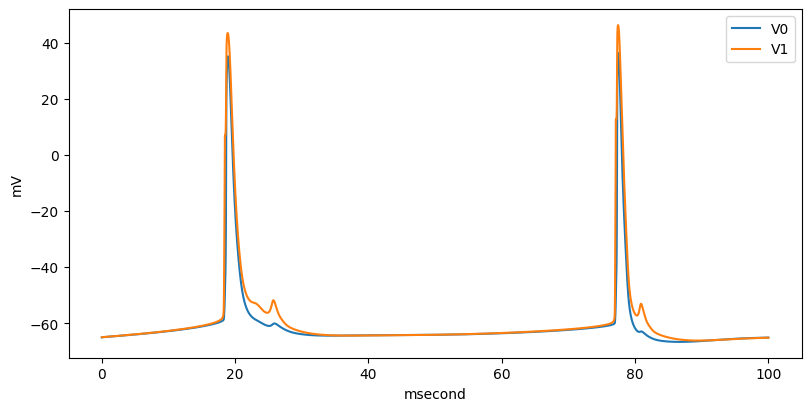

In [102]:
fig, gs = braintools.visualize.get_figure(1, 1, 4, 8)
fig.add_subplot(gs[0, 0])
plt.plot(times, vs[:, 0, 0], label="V0")
plt.plot(times, vs[:, 0, 1], label="V1")
plt.legend()
plt.show()